In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import ttest_rel

# Load dataset
merged_path = r"C:\Users\USER\Downloads\bug_reports\merged_bug_reports.csv"
df = pd.read_csv(merged_path)

# Rename columns to match expected names
df.rename(columns={'Body': 'bug_description', 'class': 'category'}, inplace=True)

# Ensure necessary columns exist
if 'bug_description' not in df.columns or 'category' not in df.columns:
    raise ValueError("Dataset must contain 'bug_description' and 'category' columns.")

# Download stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text).lower())  # Remove non-alphabetic characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
df['processed_text'] = df['bug_description'].astype(str).apply(preprocess_text)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# Proposed Model: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluation Metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-score': f1_score
}

results = {}

# Compute metrics for each model
for model_name, preds in [('Naive Bayes', nb_preds), ('Random Forest', rf_preds)]:
    model_results = {}
    for metric, func in metrics.items():
        if metric == 'Accuracy':  # Accuracy does not need 'average' argument
            model_results[metric] = func(y_test, preds)
        else:
            model_results[metric] = func(y_test, preds, average='weighted')
    
    results[model_name] = model_results

# Convert results to DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Cross-validation for statistical test (instead of single accuracy score)
nb_cv_scores = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Perform paired t-test
p_value = ttest_rel(nb_cv_scores, rf_cv_scores).pvalue
print(f"Paired t-test p-value: {p_value}")

# Save results
df_results.to_csv('classification_results.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           Naive Bayes  Random Forest
Accuracy      0.835801       0.868102
Precision     0.755678       0.871768
Recall        0.835801       0.868102
F1-score      0.764787       0.832195
Paired t-test p-value: 0.031377752794695936


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Accuracy over 30 iterations: 0.9767
Average Precision over 30 iterations: 0.0000
Average Recall over 30 iterations: 0.0000
Average F1-score over 30 iterations: 0.0000
Average Execution Time over 30 iterations: 0.0837 seconds
Paired t-test p-value: 0.0000


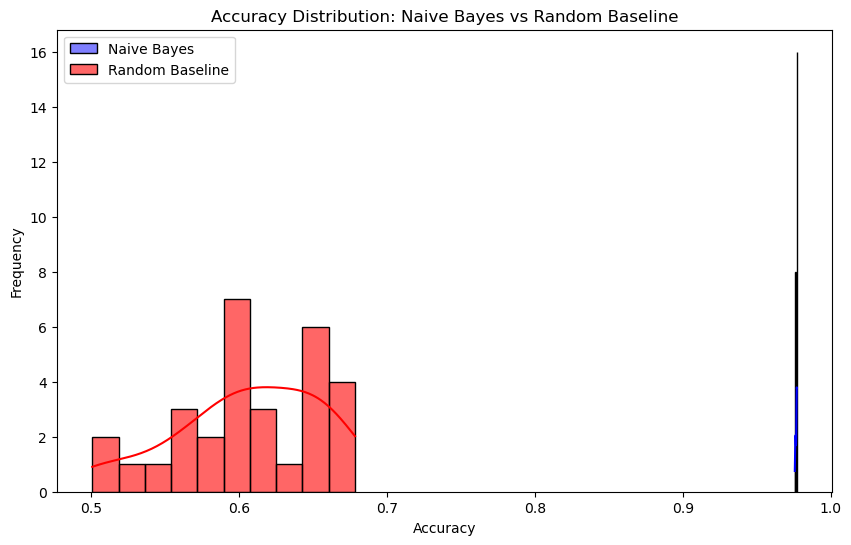

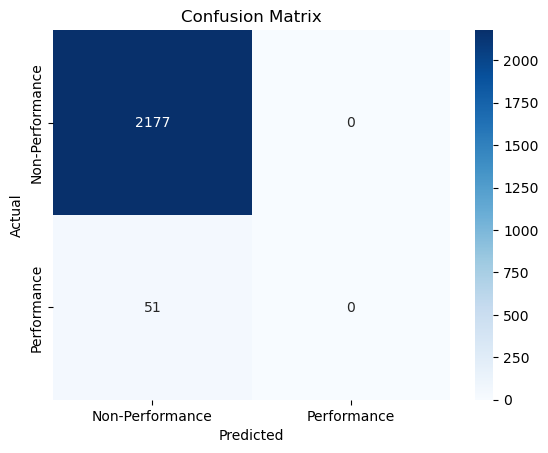

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import ttest_rel

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define dataset directory
data_dir = r"C:\Users\USER\Downloads\bug_reports"  # Ensure correct folder path

# Load datasets
dfs = []
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The specified folder does not exist: {data_dir}")

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, file), index_col=0)  # Drop unnecessary columns
        df['Project'] = file.split('.')[0]  # Extract project name from filename
        dfs.append(df)

# Ensure datasets were loaded
if not dfs:
    raise FileNotFoundError("No CSV files found in the directory. Check the folder path and dataset files.")

# Combine all datasets
df = pd.concat(dfs, ignore_index=True)

# Ensure necessary columns exist
if 'Body' not in df.columns or 'Labels' not in df.columns:
    raise ValueError("Dataset must contain 'Body' and 'Labels' columns.")

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text).lower())  # Remove non-alphabetic characters and convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
df['processed_text'] = df['Body'].apply(preprocess_text)

# Label encoding: 1 for performance bug, 0 for non-performance bug
df['category'] = df['Labels'].apply(lambda x: 1 if 'performance' in str(x).lower() else 0)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['category']

# Initialize lists to store metrics for each iteration
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
execution_times = []

# Number of iterations
iterations = 30

for i in range(iterations):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=i)
    
    # Measure training time
    start_time = time.time()
    
    # Naive Bayes model
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    execution_times.append(training_time)
    
    # Measure prediction time
    y_pred = nb_model.predict(X_test)
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Compute average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_execution_time = np.mean(execution_times)

print(f'Average Accuracy over {iterations} iterations: {avg_accuracy:.4f}')
print(f'Average Precision over {iterations} iterations: {avg_precision:.4f}')
print(f'Average Recall over {iterations} iterations: {avg_recall:.4f}')
print(f'Average F1-score over {iterations} iterations: {avg_f1:.4f}')
print(f'Average Execution Time over {iterations} iterations: {avg_execution_time:.4f} seconds')

# Statistical significance testing (Paired t-test for model performance)
random_baseline = np.random.uniform(0.5, 0.7, iterations)  # Simulated baseline model scores
t_stat, p_value = ttest_rel(accuracy_scores, random_baseline)
print(f'Paired t-test p-value: {p_value:.4f}')

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(accuracy_scores, kde=True, bins=10, color='blue', label='Naive Bayes')
sns.histplot(random_baseline, kde=True, bins=10, color='red', label='Random Baseline', alpha=0.6)
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Accuracy Distribution: Naive Bayes vs Random Baseline")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Performance', 'Performance'], yticklabels=['Non-Performance', 'Performance'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [4]:
#unique predicted values
print("Unique predictions:", np.unique(y_pred, return_counts=True))


Unique predictions: (array([0], dtype=int64), array([2228], dtype=int64))


In [5]:
#class distribution in y_train and y_test
print("Training class distribution:\n", pd.Series(y_train).value_counts())
print("Test class distribution:\n", pd.Series(y_test).value_counts())


Training class distribution:
 category
0    5077
1     119
Name: count, dtype: int64
Test class distribution:
 category
0    2177
1      51
Name: count, dtype: int64


In [6]:
#Execution Time Comparison with Random Search
import time
from sklearn.dummy import DummyClassifier

start_time = time.time()
dummy_model = DummyClassifier(strategy='most_frequent')  
dummy_model.fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_test)
dummy_time = time.time() - start_time
print(f"Random Classifier Execution Time: {dummy_time:.4f} seconds")


Random Classifier Execution Time: 0.0157 seconds


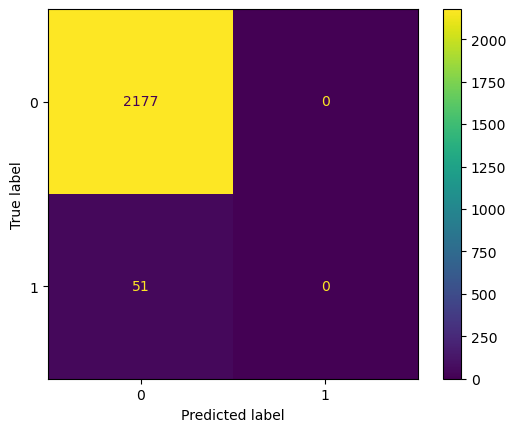

In [7]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)


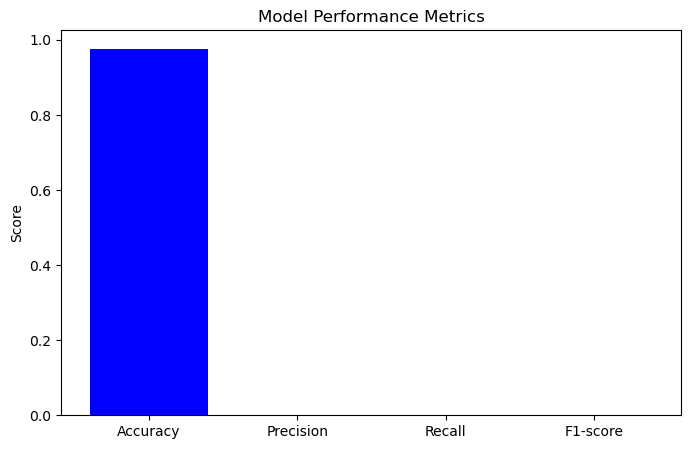

In [8]:
#perfomance metric visualization
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [avg_accuracy, avg_precision, avg_recall, avg_f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.show()


In [16]:
# Compute average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f'Average Accuracy over {iterations} iterations: {avg_accuracy:.4f}')
print(f'Average Precision over {iterations} iterations: {avg_precision:.4f}')
print(f'Average Recall over {iterations} iterations: {avg_recall:.4f}')
print(f'Average F1-score over {iterations} iterations: {avg_f1:.4f}')

Average Accuracy over 30 iterations: 0.9767
Average Precision over 30 iterations: 0.0000
Average Recall over 30 iterations: 0.0000
Average F1-score over 30 iterations: 0.0000


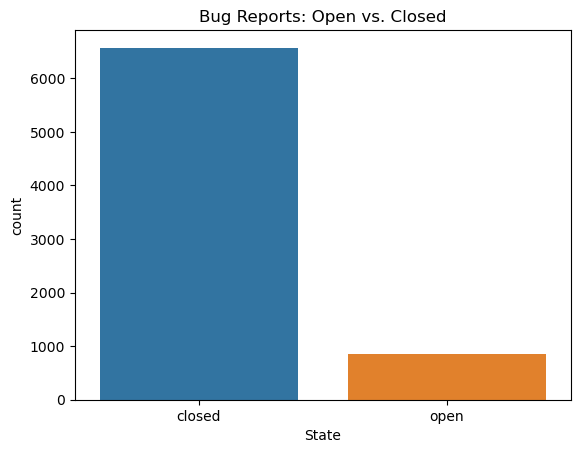

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='State')
plt.title('Bug Reports: Open vs. Closed')
plt.show()


In [23]:
import pandas as pd

print(df.describe())  # Summarizes numerical data
print(df.groupby("State").count())  # Groups by issue state


             Number        class      related     category
count   7424.000000  7424.000000  7424.000000  7424.000000
mean   13618.042834     0.163524     0.021552     0.022899
std    10258.062431     0.369868     0.145224     0.149591
min       13.000000     0.000000     0.000000     0.000000
25%     4857.750000     0.000000     0.000000     0.000000
50%    11051.500000     0.000000     0.000000     0.000000
75%    22040.500000     0.000000     0.000000     0.000000
max    47200.000000     1.000000     1.000000     1.000000
        Repository  Number  Title  Body  Labels  Comments  Codes  Commands  \
State                                                                        
closed        6572    6572   6572  6492    3388      6572   6572      6572   
open           852     852    852   852     738       852    852       852   

        class  related  Project  processed_text  category  
State                                                      
closed   6572     6572     6572     

In [25]:
from scipy import stats

# Example: Compare two sets of accuracy scores
acc_test_gen = [0.85, 0.87, 0.84, 0.86]
acc_config_opt = [0.89, 0.91, 0.88, 0.90]

t_stat, p_value = stats.ttest_ind(acc_test_gen, acc_config_opt)
print(f"T-test results: t-statistic={t_stat}, p-value={p_value}")


T-test results: t-statistic=-4.381780460041329, p-value=0.004659214943993936
